In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
import pandas as pd
import torch

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.visualization import GameVisualizer
from src.models import AE_Trainer, AELSTM
from src.datahandlers import PacmanDataset, PacmanDataReader, Trajectory


In [2]:


def slice_seq_of_each_level(
        reader: PacmanDataReader,
        start_step=0,
        end_step=-1,
        FEATURES= [
            # "score", 
            # "lives", 
            # "pacman_attack",
            "Pacman_X",
            "Pacman_Y",
            "Ghost1_X",
            "Ghost1_Y",            
            "Ghost2_X",
            "Ghost2_Y",
            "Ghost3_X",
            "Ghost3_Y",
            "Ghost4_X",
            "Ghost4_Y",
            ]
    )-> tuple[list[np.ndarray], list[dict], list[Trajectory]]:
    """
    Get a slice of each level from the start gamestep until the end_gamestep.
    If end_step is -1, get the whole level play.

    returns (list[sequences], list[dict], list[traj])
    """
    sequence_list = []
    metadata_list = []
    traj_list = []
    for level_id in reader.level_df["level_id"].unique():
        gamestates, metadata = reader._filter_gamestate_data(level_id=level_id)
        gamestates = gamestates[FEATURES]

        gamestates = gamestates.iloc[start_step:end_step]
        traj = reader.get_partial_trajectory(level_id=level_id, start_step=start_step, end_step=end_step)

        sequence_list.append(gamestates.to_numpy())
        metadata_list.append(metadata)
        traj_list.append(traj)

    return sequence_list, metadata_list, traj_list


def padding_sequences(sequence_list:list[np.ndarray], 
                      padding_value = -999.0):

    # Find the maximum sequence length
    max_seq_length = max(x.shape[0] for x in sequence_list)
    n = len(sequence_list)
    n_features = sequence_list[0].shape[1]

    # Pad sequences with np.nan (or 0, or any value) to max_seq_length
    X_padded = np.full((n, max_seq_length, n_features), padding_value , dtype=np.float32)
    for i, x in enumerate(sequence_list):
        seq_len = x.shape[0]
        X_padded[i, :seq_len, :] = x

    return X_padded

reader = PacmanDataReader(data_folder="../data")
sequence_list, meta, traj_list = slice_seq_of_each_level(reader, start_step=-100, end_step=-1)

X_padded = padding_sequences(sequence_list=sequence_list)


In [17]:

data_tensor = PacmanDataset(X_padded)
data_tensor.gamestates.shape

torch.Size([938, 99, 10])

In [ ]:
trainer = AE_Trainer(max_epochs=50, 
                     batch_size=32, 
                     validation_split=0.3)

model = AELSTM(input_size=data_tensor[0]["data"].shape[1], hidden_size=256)

# ### LOAD
# model.load_state_dict(torch.load('../hpc/trained_models/pacman_aelstm_h256_e1000_best.pth', map_location=torch.device("cpu")))
# model.eval()  # Set to evaluation mode if not training

### TRAIN
trainer.fit(model, data_tensor)

In [ ]:
## more fitting
trainer.fit(model, data_tensor)

WARNING - src.datahandlers.trajectory - Trajectory for game 1199 ends before the inputed end step (99 < 100). Returning segment until last observed position instead.
WARNING - src.datahandlers.trajectory - Trajectory for game 910 ends before the inputed end step (80 < 100). Returning segment until last observed position instead.
WARNING - src.datahandlers.trajectory - Trajectory for game 891 ends before the inputed end step (94 < 100). Returning segment until last observed position instead.
WARNING - src.datahandlers.trajectory - Trajectory for game 686 ends before the inputed end step (98 < 100). Returning segment until last observed position instead.


embedding for LSTM trained on first_5_seconds
Processed all batches in 1.1436872482299805 seconds
embedding for LSTM trained on last_5_seconds
Processed all batches in 0.9875144958496094 seconds
embedding for LSTM trained on whole_level
Processed all batches in 60.12941288948059 seconds


c:\Users\Localadmin_pabflore\miniconda3\envs\pacman_encoder\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Localadmin_pabflore\miniconda3\envs\pacman_encoder\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


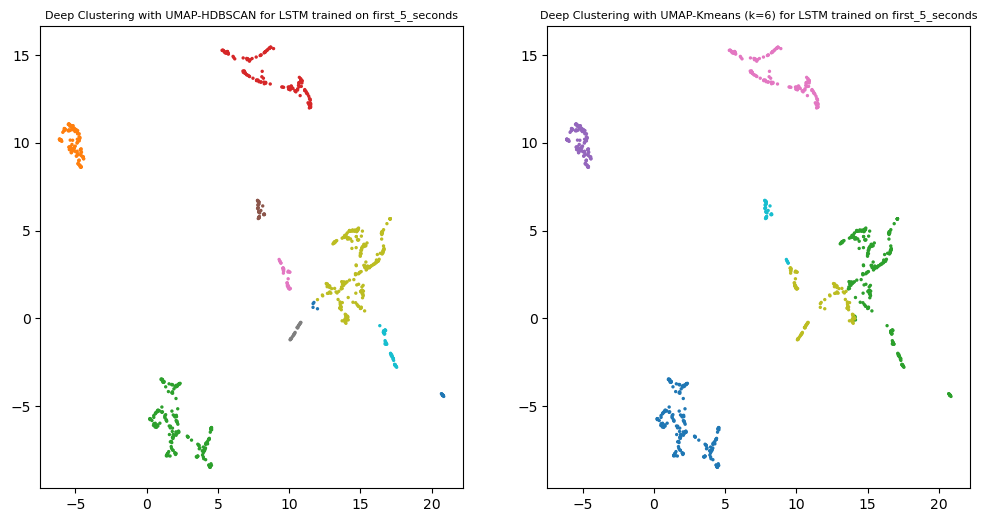

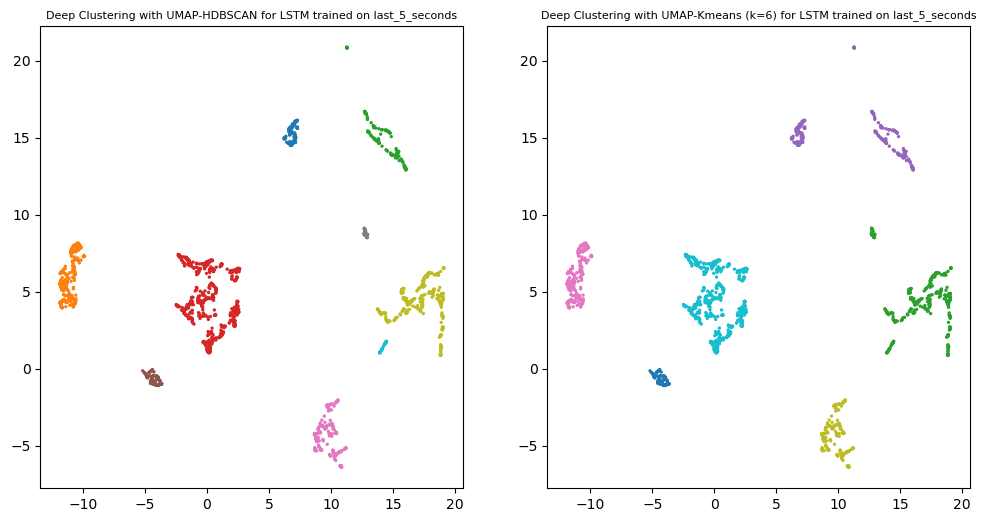

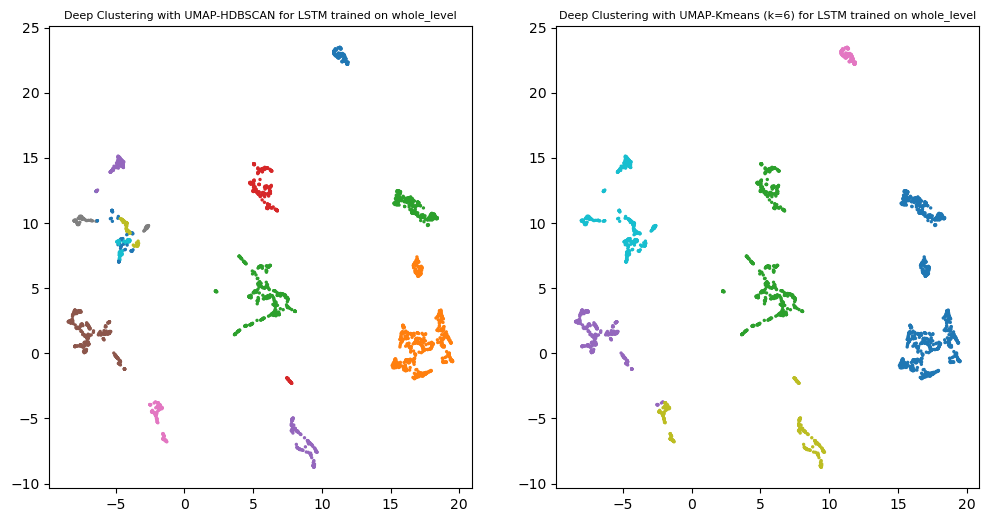

In [11]:
### Whole slicing, loading-model, embedding, reducing, clustering, plotting

sequence_types = [
    "first_5_seconds",
     "last_5_seconds",
     "whole_level"
     ]

reader = PacmanDataReader(data_folder="../data")
sequence_list, meta, traj_list = slice_seq_of_each_level(reader)
X_padded = padding_sequences(sequence_list=sequence_list)

sequences_data = []

for seq_type in sequence_types:
    if seq_type == "first_5_seconds":
        sequence_list, meta, traj_list = slice_seq_of_each_level(reader, start_step=0, end_step=100)
    elif seq_type == "whole_level":
        sequence_list, meta, traj_list = slice_seq_of_each_level(reader, start_step=0, end_step=-1)
    elif seq_type == "last_5_seconds":
        sequence_list, meta, traj_list = slice_seq_of_each_level(reader, start_step=-100, end_step=-1) 

    X_padded = padding_sequences(sequence_list=sequence_list)
    sequences_data.append(PacmanDataset(X_padded))

### LOADING MODELS
INPUT_SIZE = 2
HIDDEN_SIZE = 256
EPOCHS = 1000
models = []

for seq_type in sequence_types:
    model = AELSTM(input_size = INPUT_SIZE, hidden_size=HIDDEN_SIZE)
    model.load_state_dict(torch.load(f"../hpc/trained_models/pacman_aelstm_{seq_type}_h{HIDDEN_SIZE}_e{EPOCHS}_best.pth", map_location=torch.device('cpu')))
    model.name = (f"LSTM trained on {seq_type}")
    models.append(model)


from umap import UMAP
from sklearn.cluster import KMeans, HDBSCAN
import matplotlib.pyplot as plt
import time

### EMBEDDING AND REDUCING

# Process in batches to avoid memory issues
BATCH_SIZE = 32  # Adjust based on your available memory
all_embeddings = [] # empty list to be filled during batch processing.
reducer = UMAP()

reduced_embeddings = [] # empty lists for final results, each item would be a [n, 2] array for each model.

## Embed, and reduce the data for each model
for idx, model in enumerate(models):
    print(f"embedding for {model.name}")
    ti = time.time()
    model.eval()
    with torch.no_grad():  # Important: disable gradients for inference
        for i in range(0, len(sequences_data[idx]), BATCH_SIZE):
            batch_data = sequences_data[idx][i:i+BATCH_SIZE]["data"]
            
            # Get embeddings for this batch
            _, batch_embeddings = model.forward(batch_data, return_encoding=True)
            all_embeddings.append(batch_embeddings.cpu())  # Move to CPU to save GPU memory
            # if i%5 == 0:
            #     print(f"Processed batch {i//BATCH_SIZE + 1}/{(len(data_tensor)-1)//BATCH_SIZE + 1}")

    tf = time.time()
    print(f"Processed all batches in {tf - ti} seconds")
    # Concatenate all embeddings
    embeddings = torch.cat(all_embeddings, dim=0)
    embeddings_2D = reducer.fit_transform(embeddings.detach().numpy())

    reduced_embeddings.append(embeddings_2D)


##CLUSTERING

N_CLUSTERS = 6 ## for k-means

clusterers = {}
clusterers["HDBSCAN"] = HDBSCAN(min_cluster_size=20)
clusterers[f"Kmeans (k={N_CLUSTERS})"] = KMeans(n_clusters=6)

for idx, model in enumerate(models):
    labels = {}
    for name, clusterer in clusterers.items():
        labels[name] = clusterer.fit_predict(reduced_embeddings[idx])

    ## plot

    fig, axs = plt.subplots( 1, len(labels.values()), figsize=(6 * len(labels.values()),6))

    for i, (name, predictions) in enumerate(labels.items()):
        axs[i].scatter(reduced_embeddings[idx][:,0], reduced_embeddings[idx][:,1], s=2, cmap="tab10", c=predictions)
        axs[i].set_title(f"Deep Clustering with UMAP-{name} for {model.name}", size=8)
    
    fig.savefig(fname=f"results/DeepClusteringResults_plot_Pacman_{sequence_types[idx]}_{model.name}")



    # fig.savefig(fname="results/DeepClusteringResults_plot_Pacman_WholeSequence_LSTM")

c:\Users\Localadmin_pabflore\miniconda3\envs\pacman_encoder\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


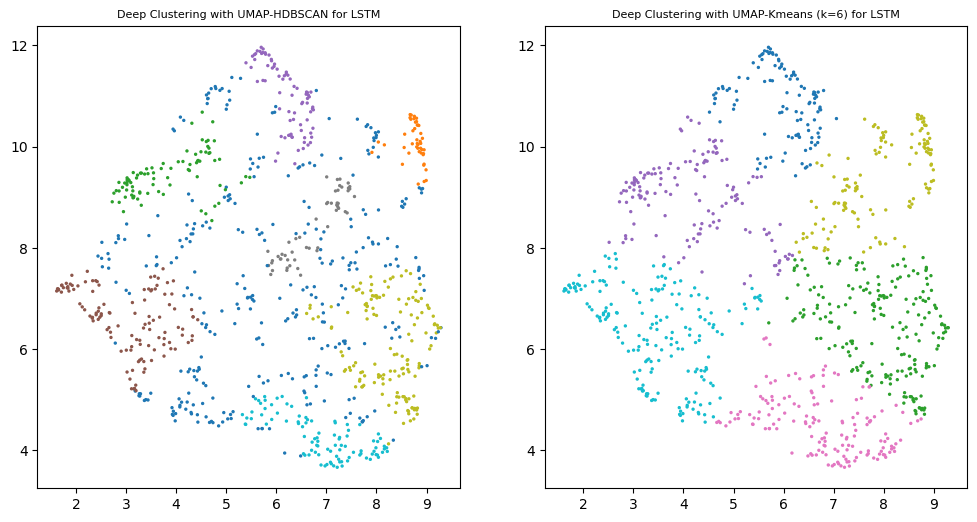

In [ ]:
from umap import UMAP
from sklearn.cluster import KMeans, HDBSCAN
import matplotlib.pyplot as plt

## embed
## Will not work when sequence length is too big, so use the batch processing below instead.
_, embeddings = model.forward(data_tensor[:]["data"], return_encoding=True)

## reduce
reducer = UMAP()
embeddings_2D = reducer.fit_transform(embeddings.detach().numpy())



clusterers = {}
clusterers["HDBSCAN"] = HDBSCAN(min_cluster_size=20)

N_CLUSTERS = 6 ## for k-means
clusterers[f"Kmeans (k={N_CLUSTERS})"] = KMeans(n_clusters=6)


labels = {}
for name, clusterer in clusterers.items():
    labels[name] = clusterer.fit_predict(embeddings_2D)

## plot

fig, axs = plt.subplots( 1, len(labels.values()), figsize=(6 * len(labels.values()),6))

for i, (name, predictions) in enumerate(labels.items()):
    axs[i].scatter(embeddings_2D[:,0], embeddings_2D[:,1], s=2, cmap="tab10", c=predictions)
    axs[i].set_title(f"Deep Clustering with UMAP-{name} for LSTM", size=8)

fig.savefig(fname=f"results/DeepClusteringResults_plot_f10_last_5_seconds_h256_e100")

INFO - src.analysis.geom_clustering - Initializing GeomClustering with similarity measure: dtw
INFO - src.analysis.geom_clustering - Fitting clustering model with 938 trajectories
INFO - src.analysis.geom_clustering - Using existing affinity matrix
INFO - src.analysis.geom_clustering - Starting HDBSCAN clustering with min_cluster_size=5 and min_samples=None
INFO - src.analysis.geom_clustering - HDBSCAN clustering complete in 0.03 seconds
INFO - src.analysis.geom_clustering - Clustering complete. Found 23 clusters


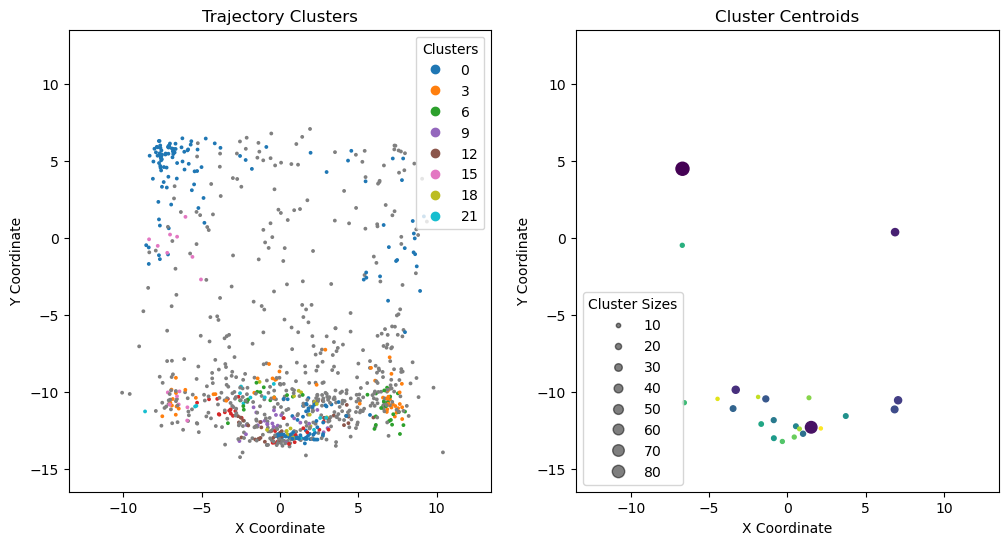

In [6]:
import src.analysis as analysis
import matplotlib.pyplot as plt

GeomClustering = analysis.GeomClustering(
    similarity_measure="dtw", cluster_method="HDBSCAN", verbose=True
)
GeomClustering.affinity_matrix = np.loadtxt("../hpc/affinity_matrices/first_200_steps_dtw_affinity_matrix.csv", delimiter=",")

GeomClustering.fit(trajectories=traj_list)

fig, axs = plt.subplots(1, 2, figsize=[12, 6])
GeomClustering.plot_trajectories_embedding(ax=axs[0])
GeomClustering.plot_clustering_centroids(ax=axs[1])


# for cluster in np.unique(GeomClustering.labels)[:7]:
#     GeomClustering.plot_cluster_overview(cluster_id=cluster, figsize=(18, 6))

In [ ]:
## UMAP-HDBSCAN CLUSTERING

import hdbscan
import umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


embeddings = pass

print(f"Dim.red and clustering {embeddings.shape[0]} levels")

reducer = umap.UMAP(n_components=2)
clustering = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=None , metric = "euclidean", algorithm = "best")

standardized_vector = StandardScaler().fit_transform(X=embeddings)

reduced_vector = reducer.fit_transform(standardized_vector)

clustering.fit(X=reduced_vector)

print(f"clustering complete. Found {len(set(clustering.labels_)) - 1} clusters")

np.unique_counts(clustering.labels_)
 

In [ ]:
## REDUCING AND PLOTTING
import umap, hdbscan, umap.plot, pacmap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

standardized = StandardScaler().fit_transform(X = encodings.reader.level_df.loc[:,["duration","level", "win", "max_score"]]) ## with level metadata

# X = encodings.get_vector_encodings().drop(columns=["Caution2a_value", "Caution2b_value", "Caution3_value"])

# standardized = StandardScaler().fit_transform(X = X)

umap_ = umap.UMAP()
tsne = TSNE(n_components=2)
pacmap_ = pacmap.PaCMAP()
pca_ = PCA(n_components=2)


DIMENSIONS = 3
reducers = {
    "umap" : umap.UMAP(n_components=DIMENSIONS),
    "tsne" : TSNE(n_components=DIMENSIONS),
    "PaCMAP" : pacmap.PaCMAP(n_components=DIMENSIONS),
    "PCA" : PCA(n_components=DIMENSIONS)
}

for reducer in reducers.values():
    reducer.reduced_data_ = reducer.fit_transform(X= standardized)

clustering = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=None , metric = "euclidean", algorithm = "best")
clustering.fit(X=standardized)

fig, axs = plt.subplots(1,len(reducers), figsize=[5*len(reducers),5])

for i, reducer in enumerate(reducers.values()):
    axs[i].scatter(reducer.reduced_data_[:, 0] , reducer.reduced_data_[:,1], c = clustering.labels_)
    axs[i].set_title(f"{list(reducers.keys())[i]} reduction")

    handles = []
    labels = []
    unique_labels = np.unique(clustering.labels_)
    for label in unique_labels:
        if label == -1:
            size = np.sum(clustering.labels_ == -1)
            handles.append(plt.Line2D([], [], marker='o', color='w', markerfacecolor='gray', markersize=6, linestyle='None'))
            labels.append(f'Noise ({size})')
        else:
            size = np.sum(clustering.labels_ == label)
            handles.append(plt.Line2D([], [], marker='o', color='w', markerfacecolor=plt.cm.tab10(label % 10), markersize=6, linestyle='None'))
            labels.append(f'Cluster {label} ({size})')
    axs[i].legend(handles, labels, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')